In [1]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import tensorflow_probability as tfp

2024-06-13 14:32:52.792194: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 14:32:52.936031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 14:32:52.936075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 14:32:52.937525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 14:32:52.957274: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# Distribution Settings
scale = 1
mean = 10

normal_dist = scipy.stats.norm(loc=mean, scale=scale)

# Number of independent datapoints 
T = 10

In [5]:
seed=360
rng = np.random.RandomState(seed)
y_T = normal_dist.rvs(size=T, random_state=rng)

# empty input just for keras 
x_TF = np.zeros(shape=(T,0))

2024-06-13 14:12:38.609015: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-13 14:12:38.609069: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-06-13 14:12:38.609077: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-06-13 14:12:38.609231: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-06-13 14:12:38.609273: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-06-13 14:12:38.609281: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


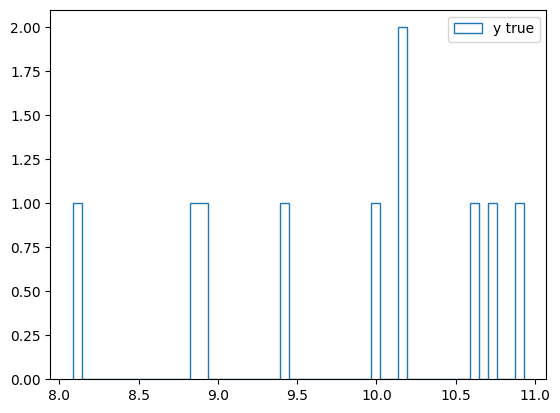

In [6]:
plt.hist(tf.reshape(y_T, [-1]).numpy(), bins=50,histtype='step', label='y true')
plt.legend()

In [7]:
inputs = keras.Input(shape=0)
# a dense layer with an empty input will just be an intercept term
intercept_layer = keras.layers.Dense(1, activation = None)
distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))

In [8]:
predicted_mean = intercept_layer(inputs)
distribution = distribution_layer(predicted_mean)
model = keras.Model(inputs=inputs, outputs=distribution)

In [9]:

model_distributions = model(x_TF)
print(f'Model parameter shapes: {[w.shape for w in model.get_weights()]}')

Model parameter shapes: [(0, 1), (1,)]


In [10]:
intercept = model.trainable_variables[1]
intercept.assign([mean])

print(f'intercept {model.get_weights()[1]}')

intercept [10.]


In [12]:
M_score = 2
@tf.function()
def get_grad(x_TF, model, M_score):
    with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
        model_distribution = model(x_TF)
        sample_y_MT_score = model_distribution.sample(M_score)

        # maybe stop?
        sample_log_probs_MT = model_distributions.log_prob(sample_y_MT_score)
    # The lowercase p indicates that this is a list of model parameters, each shape MTS+parameter shape
    jacobian_pMT = jacobian_tape.jacobian(sample_log_probs_MT, model.trainable_weights)
    return jacobian_pMT

jacobian_pMT = get_grad(x_TF, model, M_score)


In [10]:
M_score = 100000
M_action = 100000

with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
    model_distribution = model(x_TF)
    sample_y_MT_score = model_distribution.sample(M_score)
    sample_y_MT_action = model_distribution.sample(M_action)

    # maybe stop?
    sample_log_probs_MT = model_distributions.log_prob(sample_y_MT_score)
    
    sample_actions_MT = tf.identity(sample_y_MT_action)
    expected_actions_T = tf.reduce_mean(sample_actions_MT, axis=0)
    loss_T = keras.losses.mean_squared_error(y_T, expected_actions_T)
    loss = tf.reduce_mean(loss_T)

# The lowercase p indicates that this is a list of model parameters, each shape MTS+parameter shape
jacobian_pMTS = jacobian_tape.jacobian(sample_log_probs_MT, model.trainable_weights)
param_gradient_pT = [score_function_trick(j, sample_actions_MT) for j in jacobian_pMTS]
        
loss_gradients_T = loss_tape.gradient(loss_T, expected_actions_T)
overall_gradient = [overall_gradient_calculation(g, loss_gradients_T) for g in param_gradient_pT]

master_gradient = master_tape.gradient(loss_T, model.trainable_weights)

2024-06-13 13:27:37.014585: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (mklcpu) ran out of memory trying to allocate 35.53PiB (rounded to 40000000000000000)requested by op gradient_tape/UnsortedSegmentSum/pfor/UnsortedSegmentSum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-06-13 13:27:37.014618: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for mklcpu
2024-06-13 13:27:37.014629: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-06-13 13:27:37.014635: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/UnsortedSegmentSum/pfor/UnsortedSegmentSum defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_90591/4274885539.py", line 17, in <module>

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py", line 212, in f

OOM when allocating tensor with shape[10000000000000000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node gradient_tape/UnsortedSegmentSum/pfor/UnsortedSegmentSum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_f_436]

In [14]:
10000000000000000/100000/100000/1000

1000.0